## SSMI Ice data
### Cartopy quicklook

This notebook provides guidance to visualize SSMI data after it has been processed from raw binary data to csv data with columns of ice_concentration, latitude, and longitude.  It regrids the data to the users choice (default = 0.25x0.25 degree) by declaring the number of columns of latitude and longitude.

There is also timing components built in to see if and where the ingest/gridding/plotting can be spead up

__pyversion__==3.7   
__author__==S.Bell

In [1]:
import numpy as np
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmocean

In [2]:
filein = '/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1978/bt_19781231_n07_v3.1_n.csv'
df = pd.read_csv(filein)


In [3]:
df.describe()

,grid_area,ice_conc,latitude,longitude
count,136192.000000,136192.000000,136192.000000,136192.000000
mean,555.540872,16.472752,57.624520,17.489821
std,65.681213,36.083450,12.239096,104.975745
min,382.659000,0.000000,31.102670,-180.000000
25%,504.298000,0.000000,47.900800,-70.346180
50%,561.330500,0.000000,56.940085,6.666425
75%,609.645500,0.000000,66.304733,115.033140
max,664.449000,100.000000,89.836820,179.813980


In [4]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor='0.0')

### Calculate Areal Ice extent Frequency

Each time a pixel is 15% or greater, count as Ice Covered

In [5]:
dffreq = df.copy()
dffreq.drop(['grid_area'],axis=1,inplace=True)
dffreq.ice_conc = 0
dffreq.sum()

ice_conc     0.000000e+00
latitude     7.847999e+06
longitude    2.381974e+06
dtype: float64

In [6]:
dffreq['ice_conc'][df.ice_conc >= 15] = dffreq['ice_conc'][df.ice_conc >= 15] + 1

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


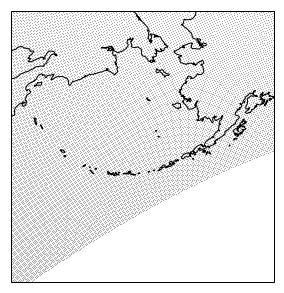

In [7]:
extent = [170, 210, 40, 68]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

ax.plot(dffreq.longitude,dffreq.latitude,'k.',markersize=.25,transform=transformation)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Define boundaries and cycle through all Bootstrap/NRT data

Currently evaluating every grid point

In [8]:
#initialize empty array
dffreq = df.copy()
dffreq.drop(['grid_area'],axis=1,inplace=True)
dffreq.ice_conc = 0

file_count = 0
import glob
for y in range(2010,2020):
    year=str(y)
    print(f"{year}")
    if year in ['2017','2018','2019']:
        path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    else:
        path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"
        
    for fname in sorted(glob.glob(path)):
        df = pd.read_csv(fname)
        dffreq['ice_conc'][df.ice_conc >= 15] = dffreq['ice_conc'][df.ice_conc >= 15] + 1
        file_count +=1

2010


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

In [9]:
### Remapping the modes from the analysis
from scipy import interpolate
from matplotlib.mlab import griddata
import matplotlib.path as mpath
import cmocean

dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

#-- Now let's grid your data.
# First we'll make a regular grid to interpolate onto. This is equivalent to
# your call to `mgrid`, but it's broken down a bit to make it easier to
# understand. 

#The number of columns and rows can be directly linked to the grid resolution
#360 cols would be 1deg resolution... 180 cols would be 2deg resolution
#the more columns, the slower the gridding process but the smoother the plot.  Too
#many columns will lead to oversampling so .25x.25 is probably the highest I would go

numcols, numrows = 360*4, 90*4
xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

# regridding data with 0's removed data
x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

In [10]:
xi

array([[-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ],
       [-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ],
       [-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ],
       ...,
       [-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ],
       [-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ],
       [-180.        , -179.74995554, -179.49991108, ...,  179.31389108,
         179.56393554,  179.81398   ]])

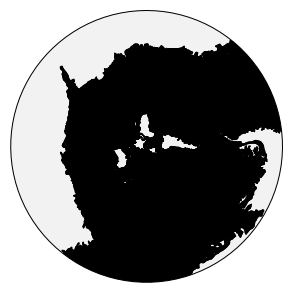

In [11]:
projection=ccrs.NorthPolarStereo(central_longitude=200.0,true_scale_latitude=0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

#cm=ax.pcolormesh(xi,yi,zi/file_count,transform=transformation,cmap=cmocean.cm.oxy, vmin=0)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')

#plt.colorbar(cm)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k', alpha=.05))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='k', alpha=1))

1978
1979
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1979/bt_19790402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1979/bt_19790915_n07_v3.1_n.csv
1980
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1980/bt_19800402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1980/bt_19800915_n07_v3.1_n.csv
1981
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1981/bt_19810401_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1981/bt_19810916_n07_v3.1_n.csv
1982
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1982/bt_19820402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1982/bt_19820915_n07_v3.1_n.csv
1983
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1983/bt_19830401_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1983/bt_1983

KeyboardInterrupt: 

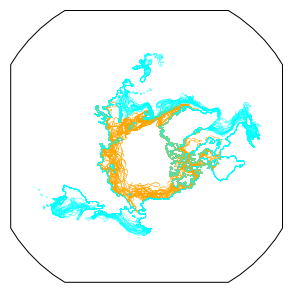

In [12]:
projection=ccrs.Orthographic(200,90)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

file_count = 0
count = 0
import glob
for y in range(1978,2020):
    year=str(y)
    print(f"{year}")
    if year in ['2018','2019','2020']:
        path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    else:
        path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"
    color=['violet','orangered',
           'blueviolet','red',
           'blue','darkred']
    for fname in sorted(glob.glob(path)):
            
        if '0401_' in fname:
            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if ('2012' in fname) or ('2018' in fname) or ('2019' in fname):
                cm=ax.contour(xi,yi,zi,levels=[15],colors=color[count],linewidths=.5,alpha=.75, transform=transformation,zorder=3)
                count +=1
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',alpha=.75,linewidths=.5, transform=transformation)


                    


        if '0915_' in fname:
            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if ('2012' in fname) or ('2018' in fname) or ('2019' in fname):
                cm=ax.contour(xi,yi,zi,levels=[15],colors=color[count],linewidths=.5,alpha=.75, transform=transformation,zorder=3)
                count +=1
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='orange',alpha=1,linewidths=.5, transform=transformation)

        if (('1978' in fname) or ('1979' in fname) or ('1980' in fname) or 
            ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
            ('1983' in fname) or ('1984' in fname) or ('1985' in fname) or
            ('1986' in fname) or (('1987' in fname) and not '0916_')):
            if '0402' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
                cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',alpha=.75,linewidths=.5, transform=transformation)

            if '0916_' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
                cm=ax.contour(xi,yi,zi,levels=[15],colors='orange',alpha=1,linewidths=.5, transform=transformation)


#ax.add_feature(land_10m,zorder=3)
#ax.coastlines(resolution='10m', edgecolor=None, facecolor='k',zorder=3)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='grey', facecolor='grey',zorder=3))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor=None, facecolor='k', alpha=.5))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='k', alpha=1,zorder=3))
#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '10m', edgecolor='k',facecolor='grey'))

In [350]:
fig.savefig('output.eps',dpi=600)
fig.savefig('output.png',dpi=600)

2010
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2010/bt_20100401_f17_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2010/bt_20100915_f17_v3.1_n.csv
2011
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2011/bt_20110401_f17_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2011/bt_20110915_f17_v3.1_n.csv
2012
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2012/bt_20120401_f17_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2012/bt_20120915_f17_v3.1_n.csv
2013
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2013/bt_20130401_f17_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2013/bt_20130915_f17_v3.1_n.csv
2014
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2014/bt_20140401_f17_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/2014/bt_20140915_

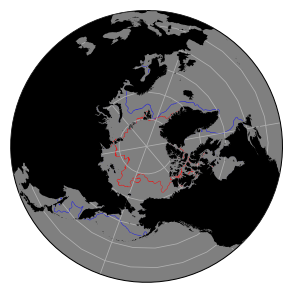

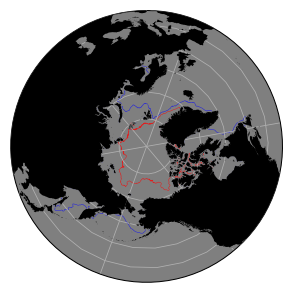

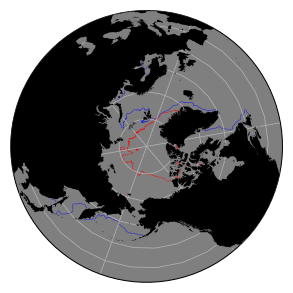

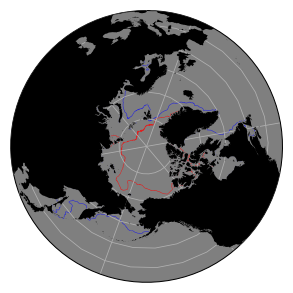

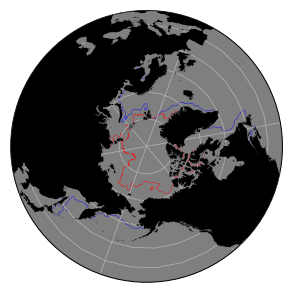

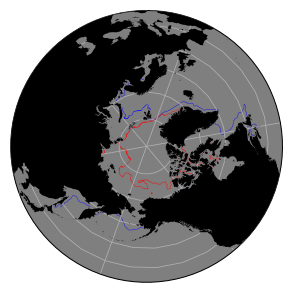

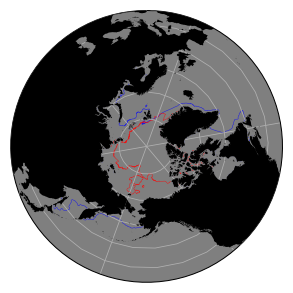

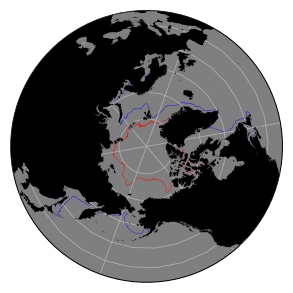

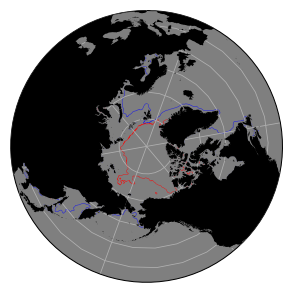

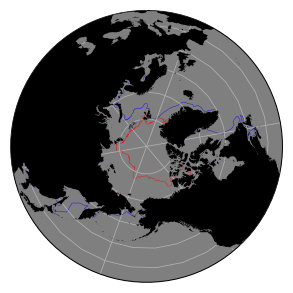

In [372]:
### Sequence of maps

projection=ccrs.Orthographic(200,90)
transformation=ccrs.PlateCarree()
#fig,ax = make_map(projection=projection)

file_count = 0
count = 0
import glob
for y in range(2010,2020):
    year=str(y)
    print(f"{year}")
    if year in ['2018','2019','2020']:
        path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    else:
        path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"
    color=['violet','orangered',
           'blueviolet','red',
           'blue','darkred']
    for fname in sorted(glob.glob(path)):
        if '0401_' in fname:
            fig,ax = make_map(projection=projection)
            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if int(year) < 2010:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',linewidths=.5,alpha=.75, transform=transformation)
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='blue',alpha=.75,linewidths=.5, transform=transformation)


                    


        if '0915_' in fname:
            

            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if int(year) < 2010:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='orange',linewidths=.5,alpha=.75, transform=transformation)
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='red',alpha=.75,linewidths=.5, transform=transformation)

            #ax.add_feature(land_10m,zorder=3)
            #ax.coastlines(resolution='10m', edgecolor=None, facecolor='k',zorder=3)

            # Compute a circle in axes coordinates, which we can use as a boundary
            # for the map. We can pan/zoom as much as we like - the boundary will be
            # permanently circular.
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)

            ax.set_boundary(circle, transform=ax.transAxes)
            ax.gridlines()
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='grey', facecolor='grey',zorder=3))
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor=None, facecolor='k', alpha=.5))
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='k', alpha=1,zorder=3))
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '10m', edgecolor='k',facecolor='grey'))
            fig.savefig(fname.replace('csv','png'),dpi=600)


In [358]:
fig.savefig('output_2.eps',dpi=600)
fig.savefig('output_2.png',dpi=600)

1978
1979
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1979/bt_19790402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1979/bt_19790915_n07_v3.1_n.csv
1980
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1980/bt_19800402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1980/bt_19800915_n07_v3.1_n.csv
1981
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1981/bt_19810401_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1981/bt_19810916_n07_v3.1_n.csv
1982
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1982/bt_19820402_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1982/bt_19820915_n07_v3.1_n.csv
1983
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1983/bt_19830401_n07_v3.1_n.csv
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1983/bt_1983

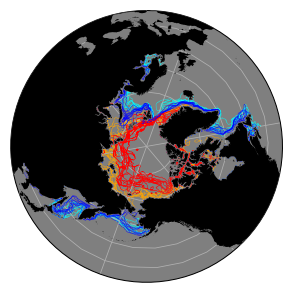

In [9]:
# generational compare
projection=ccrs.Orthographic(200,90)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

file_count = 0
count = 0
import glob
for y in range(1978,2020):
    year=str(y)
    print(f"{year}")
    if year in ['2018','2019','2020']:
        path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    else:
        path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"

    for fname in sorted(glob.glob(path)):
        if not (('197' in fname) or ('1980' in fname) or 
            ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
            ('1984' in fname) or ('1985' in fname) or ('1986' in fname) or
            ('1987' in fname) or ('201' in fname)):
            continue
            
        if '0401_' in fname:
            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if (('197' in fname) or ('1980' in fname) or 
                ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
                ('1984' in fname) or ('1985' in fname) or
                ('1986' in fname) or ('1987' in fname)):
                cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',linewidths=.5,alpha=.75, transform=transformation)
                count +=1
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='blue',alpha=.75,linewidths=.5, transform=transformation,zorder=3)


                    


        if '0915_' in fname:
            print(fname)
            dffreq = pd.read_csv(fname)
            
            
            #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

            #-- Now let's grid your data.
            # First we'll make a regular grid to interpolate onto. This is equivalent to
            # your call to `mgrid`, but it's broken down a bit to make it easier to
            # understand. 

            #The number of columns and rows can be directly linked to the grid resolution
            #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
            #the more columns, the slower the gridding process but the smoother the plot.  Too
            #many columns will lead to oversampling so .25x.25 is probably the highest I would go

            numcols, numrows = 360*4, 90*4
            xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
            yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
            xi, yi = np.meshgrid(xi, yi)

            # regridding data with 0's removed data
            x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
            zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
        
            if (('197' in fname) or ('1980' in fname) or 
                ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
                ('1984' in fname) or ('1985' in fname) or
                ('1986' in fname) or ('1987' in fname)):
                cm=ax.contour(xi,yi,zi,levels=[15],colors='orange',linewidths=.5,alpha=.75, transform=transformation)
                count +=1
            else:
                cm=ax.contour(xi,yi,zi,levels=[15],colors='red',alpha=1,linewidths=.5, transform=transformation,zorder=3)

        if (('1978' in fname) or ('1979' in fname) or ('1980' in fname) or 
            ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
            ('1984' in fname) or ('1985' in fname) or ('1986' in fname) or 
            (('1987' in fname) and not ('0916_' in fname))):
            if '0402' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
                if (('197' in fname) or ('1980' in fname) or 
                    ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
                    ('1984' in fname) or ('1985' in fname) or
                    ('1986' in fname) or ('1987' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',linewidths=.5,alpha=.75, transform=transformation)
                    count +=1
                else:
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='blue',alpha=1,linewidths=.5, transform=transformation,zorder=3)

            if '0916_' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')
                if (('197' in fname) or ('1980' in fname) or 
                    ('1981' in fname) or ('1982' in fname) or ('1983' in fname) or
                    ('1984' in fname) or ('1985' in fname) or
                    ('1986' in fname) or ('1987' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='orange',linewidths=.5,alpha=.75, transform=transformation)
                    count +=1
                else:
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='red',alpha=1,linewidths=.5, transform=transformation,zorder=3)


#ax.add_feature(land_10m,zorder=3)
#ax.coastlines(resolution='10m', edgecolor=None, facecolor='k',zorder=3)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='grey', facecolor='grey',zorder=3))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor=None, facecolor='k', alpha=.5))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='k', alpha=1,zorder=3))
#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '10m', edgecolor='k',facecolor='grey'))

In [10]:
fig.savefig('output_3.eps',dpi=600)
fig.savefig('output_3.png',dpi=600)

## Barrents and Bering only

```
Kevin Wood - NOAA Affiliate

I think the best option is to plot edges:

Bering on March 20
all in lighter grey with overplot as
light blue (ranked 5 max years)
2012
2013
2000
1995
2010
dark blue (ranked min years)
2018
2019
2017
2015
1979
with the same treatment of the coastline mask as earlier.

Barents on April 15
all in lighter grey with overplot as
light blue (ranked 5 max years)
1979
1981
1982
1998
1999
dark blue (ranked min years)
2016
2012
2017
2018
2008
```

1978
1979
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1979/bt_19790414_n07_v3.1_n.csv
1980
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1980/bt_19800414_n07_v3.1_n.csv
1981
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1981/bt_19810415_n07_v3.1_n.csv
1982
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1982/bt_19820414_n07_v3.1_n.csv
1983
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1983/bt_19830415_n07_v3.1_n.csv
1984
1985
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1985/bt_19850414_n07_v3.1_n.csv
1986
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1986/bt_19860415_n07_v3.1_n.csv
1987
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1987/bt_19870414_n07_v3.1_n.csv
1988
/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1988/bt_19880415_f08_v3.1_n.csv
1989
/Users/bell/in_and_outbox/data_sets/gsfc_bootstra

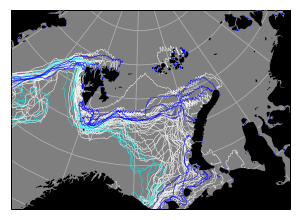

In [38]:
# barents vs bering - 4/15 vs 3/20 - different years for max/min
projection=ccrs.Orthographic(37.5,90) #200 for bering, 37.5 for barents?
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

file_count = 0
count = 0
import glob
for y in range(1978,2020):
    year=str(y)
    print(f"{year}")
    if year in ['2018','2019','2020']:
        path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    else:
        path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"

    for fname in sorted(glob.glob(path)):
        if not (('197' in fname) or ('1980' in fname) or  ('1982' in fname) or
            ('1984' in fname) or ('1985' in fname) or ('1987' in fname)):

            if '0415_' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

                if (('1979' in fname) or ('1981' in fname) or 
                    ('1982' in fname) or ('1998' in fname) or ('1999' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',linewidths=.5,alpha=.75, transform=transformation,zorder=3)
                    count +=1
                elif (('2008' in fname) or ('2012' in fname) or 
                    ('2016' in fname) or ('2017' in fname) or ('2018' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='blue',alpha=.75,linewidths=.75, transform=transformation,zorder=3)
                else:
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='whitesmoke',linewidths=.5, transform=transformation,zorder=2)
           
                    
        else:
            if '0414_' in fname:
                print(fname)
                dffreq = pd.read_csv(fname)


                #dffreq['ice_conc'][dffreq['ice_conc']==0] = np.nan

                #-- Now let's grid your data.
                # First we'll make a regular grid to interpolate onto. This is equivalent to
                # your call to `mgrid`, but it's broken down a bit to make it easier to
                # understand. 

                #The number of columns and rows can be directly linked to the grid resolution
                #360 cols would be 1deg resolution... 180 cols would be 2deg resolution
                #the more columns, the slower the gridding process but the smoother the plot.  Too
                #many columns will lead to oversampling so .25x.25 is probably the highest I would go

                numcols, numrows = 360*4, 90*4
                xi = np.linspace(dffreq.longitude.min(), dffreq.longitude.max(), numcols)
                yi = np.linspace(dffreq.latitude.min(), dffreq.latitude.max(), numrows)
                xi, yi = np.meshgrid(xi, yi)

                # regridding data with 0's removed data
                x, y, z = dffreq.longitude.values, dffreq.latitude.values, dffreq.ice_conc.values
                zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

                if (('1979' in fname) or ('1981' in fname) or 
                    ('1982' in fname) or ('1998' in fname) or ('1999' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='cyan',linewidths=.5,alpha=.75, transform=transformation,zorder=3)
                    count +=1
                elif (('2008' in fname) or ('2012' in fname) or 
                    ('2016' in fname) or ('2017' in fname) or ('2018' in fname)):
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='blue',alpha=.75,linewidths=.75, transform=transformation,zorder=3)
                else:
                    cm=ax.contour(xi,yi,zi,levels=[15],colors='whitesmoke',linewidths=.5, transform=transformation,zorder=2)
           
                    



#ax.add_feature(land_10m,zorder=3)
#ax.coastlines(resolution='10m', edgecolor=None, facecolor='k',zorder=3)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

extent = [170, 210, 45, 68] # bering
extent = [10, 70, 65, 85] # barents
ax.set_extent(extent)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='grey', facecolor='grey',zorder=3))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor=None, facecolor='k', alpha=.5))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='k', alpha=1,zorder=3))
#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '10m', edgecolor='k',facecolor='grey'))

In [39]:
fig.savefig('output_4barents.eps',dpi=600)
fig.savefig('output_4barents.png',dpi=600)